# DPG for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
state = env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111, 24) (1111, 4) (1111, 24) (1111,)
dtypes: float64 float32 float64 float64
states: 0.99992806 -0.9998551
actions: 2.6832151412963867 -2.2642688751220703
rewards: 2.6832151412963867 -2.2642688751220703


In [8]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.026832151412963866 -0.022642688751220705


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.float64, [None, action_size], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs

In [10]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [11]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [12]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    gloss = -tf.reduce_mean(gQs)
    dQs = discriminator(actions=actions, hidden_size=hidden_size, states=states, reuse=True)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.square(dQs - targetQs))
    return actions_logits, gQs, gloss, dloss

In [13]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [17]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.001           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e6)            # memory capacity
batch_size = 128                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [18]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [19]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # # Explore (Env) or Exploit (Model): NO
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.reshape(action_logits, [-1]) # For continuous/box action space
                #action = np.argmax(action_logits) # For discrete action space
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) <= -200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-105.6863 R:-105.6863 gloss:-0.2981 dloss:11.9145 exploreP:0.9883
Episode:1 meanR:-108.5911 R:-111.4959 gloss:-0.4194 dloss:14.0576 exploreP:0.9823
Episode:2 meanR:-110.1819 R:-113.3635 gloss:-0.5957 dloss:9.4472 exploreP:0.9766
Episode:3 meanR:-109.4639 R:-107.3098 gloss:-1.4342 dloss:5.0787 exploreP:0.9688
Episode:4 meanR:-107.4892 R:-99.5907 gloss:-10.2744 dloss:7.4742 exploreP:0.9591
Episode:5 meanR:-106.2025 R:-99.7688 gloss:-49.8933 dloss:30.6828 exploreP:0.9529
Episode:6 meanR:-107.6474 R:-116.3167 gloss:-118.0714 dloss:39.7755 exploreP:0.9463
Episode:7 meanR:-109.1838 R:-119.9390 gloss:-224.0106 dloss:38.2032 exploreP:0.9342
Episode:8 meanR:-107.6685 R:-95.5461 gloss:-322.6204 dloss:27.7238 exploreP:0.9267
Episode:9 meanR:-106.8558 R:-99.5410 gloss:-446.8071 dloss:25.5212 exploreP:0.9202
Episode:10 meanR:-105.0095 R:-86.5471 gloss:-2969.5061 dloss:27.0932 exploreP:0.7843
Episode:11 meanR:-106.3697 R:-121.3318 gloss:-7542.9813 dloss:26.0070 exploreP:0.7780
Episod

Episode:95 meanR:-107.1996 R:-102.1197 gloss:-133553.6209 dloss:262.1924 exploreP:0.4151
Episode:96 meanR:-107.4018 R:-126.8142 gloss:-196405.9562 dloss:736.4032 exploreP:0.4103
Episode:97 meanR:-107.3777 R:-105.0379 gloss:-126106.9242 dloss:218.3277 exploreP:0.4077
Episode:98 meanR:-107.3399 R:-103.6396 gloss:-130479.6991 dloss:253.7859 exploreP:0.4053
Episode:99 meanR:-107.2957 R:-102.9219 gloss:-141096.4287 dloss:450.2492 exploreP:0.4023
Episode:100 meanR:-107.2758 R:-103.6910 gloss:-140936.7175 dloss:188.5476 exploreP:0.4000
Episode:101 meanR:-107.1882 R:-102.7386 gloss:-223209.1390 dloss:464.8660 exploreP:0.3971
Episode:102 meanR:-107.0890 R:-103.4421 gloss:-157866.1986 dloss:475.8761 exploreP:0.3949
Episode:103 meanR:-107.1009 R:-108.5018 gloss:-189376.7879 dloss:427.2674 exploreP:0.3919
Episode:104 meanR:-107.1349 R:-102.9862 gloss:-119369.8963 dloss:371.6038 exploreP:0.3883
Episode:105 meanR:-107.4390 R:-130.1877 gloss:-182960.1402 dloss:495.7911 exploreP:0.3838
Episode:106 mea

Episode:186 meanR:-107.8003 R:-131.5220 gloss:-1354773.6493 dloss:4517.3328 exploreP:0.2210
Episode:187 meanR:-107.8265 R:-106.0084 gloss:-926676.0474 dloss:5092.9317 exploreP:0.2198
Episode:188 meanR:-107.8741 R:-107.7282 gloss:-1375316.2890 dloss:2167.4940 exploreP:0.2186
Episode:189 meanR:-107.8671 R:-103.0821 gloss:-1580573.6210 dloss:1432.1948 exploreP:0.2175
Episode:190 meanR:-107.8627 R:-105.2540 gloss:-1545815.2210 dloss:7073.5031 exploreP:0.2162
Episode:191 meanR:-107.6997 R:-105.6118 gloss:-1083729.3168 dloss:18761.5720 exploreP:0.2151
Episode:192 meanR:-108.0053 R:-132.9595 gloss:-1308529.7226 dloss:1175.2716 exploreP:0.2122
Episode:193 meanR:-107.9724 R:-103.1793 gloss:-1398984.7393 dloss:1728.1260 exploreP:0.2108
Episode:194 meanR:-107.9935 R:-103.2693 gloss:-1687470.2272 dloss:2700.1974 exploreP:0.2092
Episode:195 meanR:-108.0156 R:-104.3293 gloss:-1585387.7907 dloss:4433.7016 exploreP:0.2080
Episode:196 meanR:-107.8193 R:-107.1903 gloss:-2112693.4608 dloss:4561.3415 expl

Episode:275 meanR:-106.1892 R:-107.1313 gloss:-7695331.8512 dloss:23711.7965 exploreP:0.1256
Episode:276 meanR:-106.2096 R:-108.6129 gloss:-6666952.3854 dloss:14489.3450 exploreP:0.1249
Episode:277 meanR:-106.2286 R:-103.7669 gloss:-6310461.0314 dloss:43893.7293 exploreP:0.1239
Episode:278 meanR:-106.2351 R:-103.4254 gloss:-6339199.9104 dloss:5789.5325 exploreP:0.1232
Episode:279 meanR:-106.2448 R:-102.9327 gloss:-6353544.5373 dloss:3755.8493 exploreP:0.1226
Episode:280 meanR:-106.2544 R:-106.9675 gloss:-11652013.4853 dloss:28109.6713 exploreP:0.1220
Episode:281 meanR:-106.2351 R:-102.3050 gloss:-6937010.4863 dloss:8660.9771 exploreP:0.1211
Episode:282 meanR:-106.2369 R:-104.7426 gloss:-8426128.0711 dloss:11422.1024 exploreP:0.1204
Episode:283 meanR:-106.4788 R:-129.1963 gloss:-7409045.6945 dloss:11237.5743 exploreP:0.1192
Episode:284 meanR:-106.4657 R:-104.3843 gloss:-7253608.1634 dloss:4682.4354 exploreP:0.1184
Episode:285 meanR:-106.2415 R:-103.1356 gloss:-5869059.5006 dloss:8511.90

Episode:363 meanR:-106.0813 R:-106.8792 gloss:-16833030.3880 dloss:15695.2994 exploreP:0.0725
Episode:364 meanR:-106.1245 R:-107.4415 gloss:-19632362.3646 dloss:25007.8371 exploreP:0.0718
Episode:365 meanR:-106.1007 R:-103.6971 gloss:-31456189.0752 dloss:37619.1785 exploreP:0.0713
Episode:366 meanR:-105.8363 R:-103.8786 gloss:-19288094.5301 dloss:15763.9928 exploreP:0.0709
Episode:367 meanR:-105.8118 R:-102.6710 gloss:-26052269.6755 dloss:27608.6234 exploreP:0.0703
Episode:368 meanR:-105.7787 R:-102.4891 gloss:-8782514.0343 dloss:144316.3094 exploreP:0.0698
Episode:369 meanR:-105.7734 R:-102.5124 gloss:-23167432.8488 dloss:18177.0254 exploreP:0.0693
Episode:370 meanR:-105.7694 R:-102.3507 gloss:-24511377.0491 dloss:52942.5981 exploreP:0.0689
Episode:371 meanR:-105.7616 R:-103.3186 gloss:-27049876.9897 dloss:60278.6100 exploreP:0.0685
Episode:372 meanR:-105.7584 R:-102.6684 gloss:-40193343.6353 dloss:84115.3724 exploreP:0.0681
Episode:373 meanR:-105.7505 R:-103.6589 gloss:-25876182.0317

Episode:450 meanR:-105.6537 R:-102.3993 gloss:-62341390.6646 dloss:42541.4502 exploreP:0.0436
Episode:451 meanR:-105.6574 R:-103.3670 gloss:-63688216.6028 dloss:53900.9026 exploreP:0.0433
Episode:452 meanR:-105.6612 R:-105.1758 gloss:-55588399.4849 dloss:68291.9648 exploreP:0.0431
Episode:453 meanR:-105.6101 R:-101.8284 gloss:-42253676.9415 dloss:70165.2606 exploreP:0.0429
Episode:454 meanR:-105.5975 R:-102.6261 gloss:-62841231.8197 dloss:197107.2067 exploreP:0.0427
Episode:455 meanR:-105.5911 R:-102.9657 gloss:-65035768.4574 dloss:76737.8689 exploreP:0.0424
Episode:456 meanR:-105.2478 R:-102.1784 gloss:-404960.1554 dloss:845944.3936 exploreP:0.0422
Episode:457 meanR:-105.1899 R:-101.9597 gloss:-57582658.4546 dloss:121830.2766 exploreP:0.0420
Episode:458 meanR:-105.1419 R:-101.8269 gloss:-60596995.1238 dloss:22047.6307 exploreP:0.0417
Episode:459 meanR:-105.1088 R:-104.7026 gloss:-53498993.3508 dloss:13698.9223 exploreP:0.0415
Episode:460 meanR:-105.0764 R:-103.7486 gloss:-63087867.020

Episode:537 meanR:-105.2307 R:-103.9467 gloss:-304579158.2716 dloss:653552.6115 exploreP:0.0259
Episode:538 meanR:-105.2021 R:-101.8299 gloss:-114453869.3526 dloss:106025.6033 exploreP:0.0258
Episode:539 meanR:-105.1882 R:-102.0446 gloss:-105830317.9643 dloss:37688.3926 exploreP:0.0257
Episode:540 meanR:-105.1379 R:-101.8296 gloss:-303630759.3687 dloss:790274.9467 exploreP:0.0255
Episode:541 meanR:-105.0996 R:-102.8538 gloss:-210990450.6691 dloss:559584.0626 exploreP:0.0254
Episode:542 meanR:-105.0879 R:-102.3743 gloss:-148331574.5657 dloss:1138763.1134 exploreP:0.0253
Episode:543 meanR:-104.7851 R:-101.8399 gloss:-103851375.5610 dloss:91598.7658 exploreP:0.0251
Episode:544 meanR:-104.4643 R:-103.0008 gloss:-136877325.9129 dloss:52682.8274 exploreP:0.0250
Episode:545 meanR:-104.4555 R:-102.4221 gloss:-140869431.9670 dloss:81017.9042 exploreP:0.0249
Episode:546 meanR:-104.4106 R:-102.0685 gloss:-153205653.8497 dloss:148202.5333 exploreP:0.0247
Episode:547 meanR:-104.3810 R:-103.0913 glo

Episode:623 meanR:-104.1020 R:-102.3784 gloss:-162448248.3467 dloss:337767.6206 exploreP:0.0164
Episode:624 meanR:-104.0827 R:-102.3110 gloss:-167498300.6540 dloss:169960.4881 exploreP:0.0163
Episode:625 meanR:-104.0168 R:-101.8280 gloss:-303468134.6312 dloss:211506.9204 exploreP:0.0162
Episode:626 meanR:-103.9995 R:-101.7723 gloss:-245207746.0265 dloss:117985.5488 exploreP:0.0162
Episode:627 meanR:-103.9878 R:-102.1442 gloss:-252841313.8465 dloss:2010060.5285 exploreP:0.0161
Episode:628 meanR:-103.9380 R:-101.7739 gloss:-236457828.7550 dloss:1544828.0926 exploreP:0.0160
Episode:629 meanR:-103.9185 R:-101.8529 gloss:-274343069.9564 dloss:145873.6726 exploreP:0.0159
Episode:630 meanR:-103.9179 R:-103.3053 gloss:-253984421.4479 dloss:319776.5182 exploreP:0.0158
Episode:631 meanR:-103.8825 R:-103.4337 gloss:-312834277.2747 dloss:2123105.9244 exploreP:0.0157
Episode:632 meanR:-103.8963 R:-103.4336 gloss:-131131624.7938 dloss:843731.2254 exploreP:0.0156
Episode:633 meanR:-103.8899 R:-103.96

Episode:709 meanR:-103.2846 R:-101.8290 gloss:-569901791.3598 dloss:1413255.6946 exploreP:0.0105
Episode:710 meanR:-103.2885 R:-102.7790 gloss:-228789344.6203 dloss:805642.7162 exploreP:0.0105
Episode:711 meanR:-103.2375 R:-101.8364 gloss:-631974599.5172 dloss:487552.0356 exploreP:0.0104
Episode:712 meanR:-103.2257 R:-102.5636 gloss:-323826634.1759 dloss:400415.6534 exploreP:0.0103
Episode:713 meanR:-103.2615 R:-107.0160 gloss:-570049893.6332 dloss:456499.1437 exploreP:0.0103
Episode:714 meanR:-103.2609 R:-102.3243 gloss:-327433407.0921 dloss:236858.6022 exploreP:0.0102
Episode:715 meanR:-103.2284 R:-102.5641 gloss:-306284796.2253 dloss:451398.7931 exploreP:0.0102
Episode:716 meanR:-103.2745 R:-106.7561 gloss:-319004556.4239 dloss:5089016.4364 exploreP:0.0101
Episode:717 meanR:-103.3263 R:-107.0129 gloss:-586323872.3669 dloss:2574261.6968 exploreP:0.0101
Episode:718 meanR:-103.3696 R:-106.9662 gloss:-407157494.7485 dloss:2948622.5137 exploreP:0.0101
Episode:719 meanR:-103.3459 R:-102.5

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

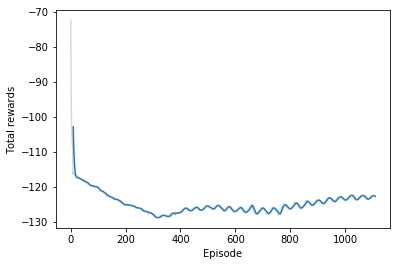

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

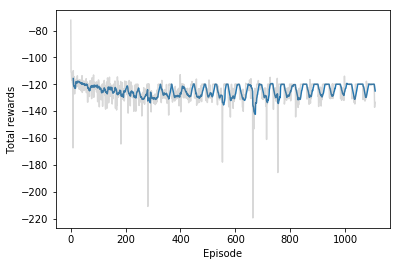

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

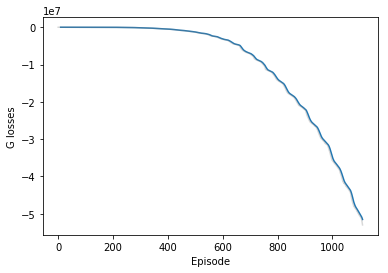

In [44]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

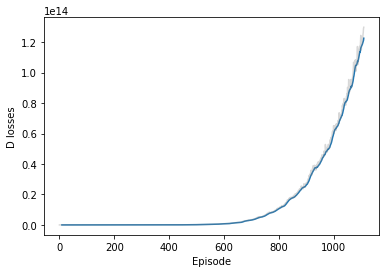

In [45]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [46]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -130.50857430583363


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.